#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
#pd.set_option('plotting.backend', 'plotly')
pd.set_option('plotting.backend', 'matplotlib')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from datetime import datetime

In [2]:
# Константы
SAMPLE_SIZE = 200
RS = 12345  # random seed
CRIT_RMSE = 48
ML = 1 # max lag
RMS = 24 # rolling mean size

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные отсортированы по времени: True
Имеем данные за период: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


<AxesSubplot:title={'center':'Исходные значения'}, xlabel='Время заказа', ylabel='Количество заказов'>

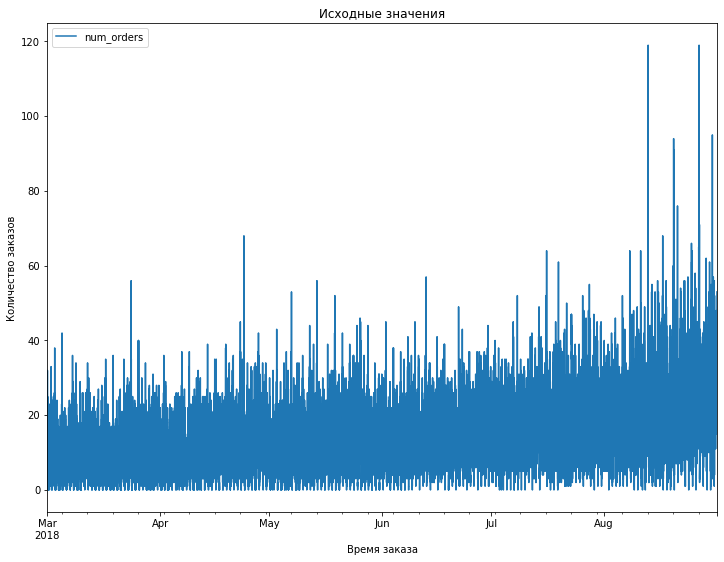

In [3]:
data = pd.read_csv(r'c:\Users\e.yumagulov\datasets\taxi.csv', index_col=[0], parse_dates=[0])
data.info()
display(data.head())
display(data.describe())
data.sort_index(inplace=True)
print('Данные отсортированы по времени:', data.index.is_monotonic)
print('Имеем данные за период:', data.index.min(), '-', data.index.max())
data.plot(figsize=[12,9], title='Исходные значения', xlabel='Время заказа', ylabel='Количество заказов')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:title={'center':'Значения ресемплированные с интервалом в 1 час'}, xlabel='Время заказа', ylabel='Количество заказов'>

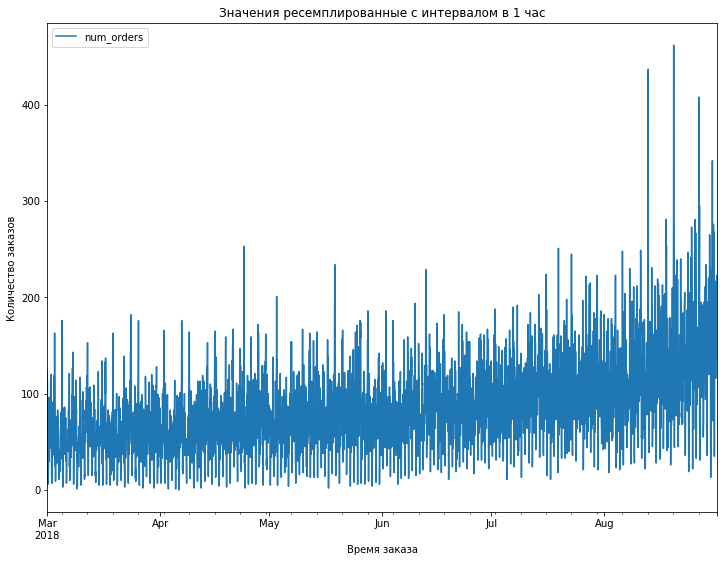

In [4]:
data = data.resample('1H').sum()
data = data.dropna()
data.info()
data.plot(figsize=[12,9], title='Значения ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')

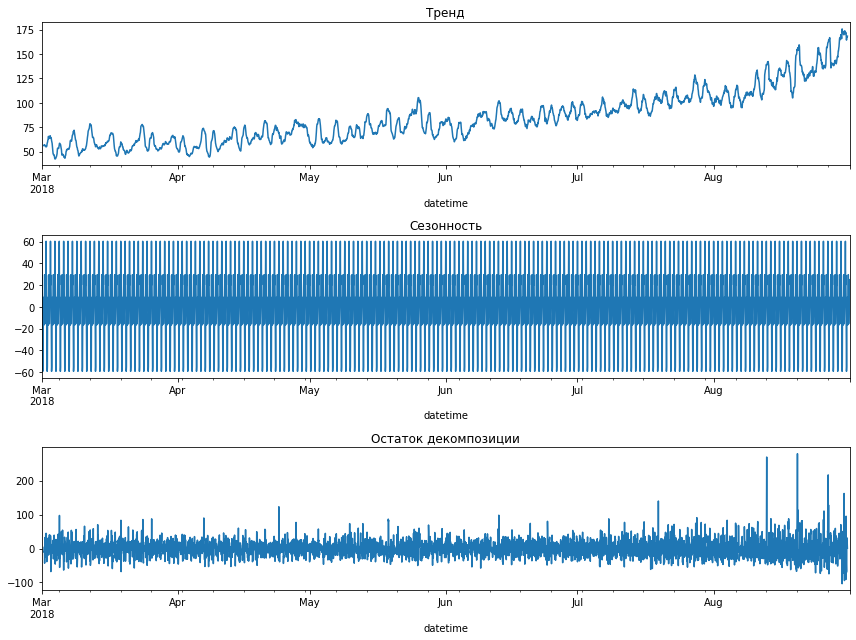

In [5]:
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(12,9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')
plt.tight_layout()

Text(0.5, 1.0, 'Сезонность за май')

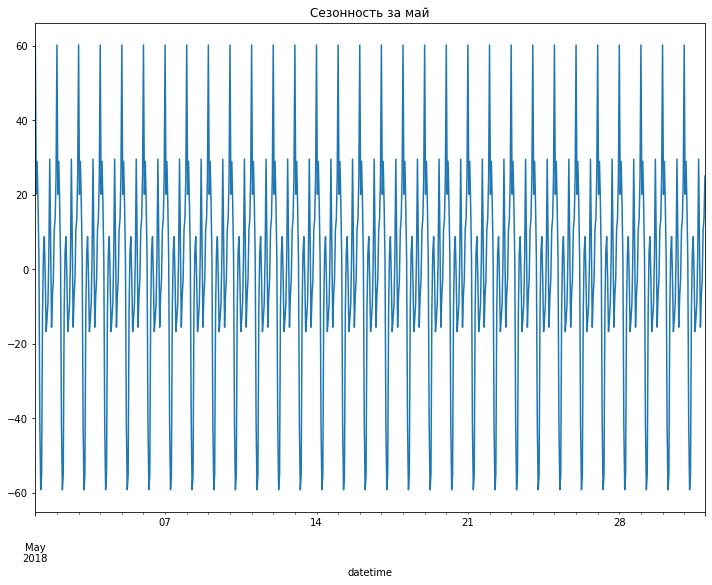

In [6]:
plt.figure(figsize=(12,9))
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca()) 
plt.title('Сезонность за май')

## Анализ

<AxesSubplot:title={'center':'Значения, скользящее среднее, стандартное отклонение, ресемплированные с интервалом в 1 час'}, xlabel='Время заказа', ylabel='Количество заказов'>

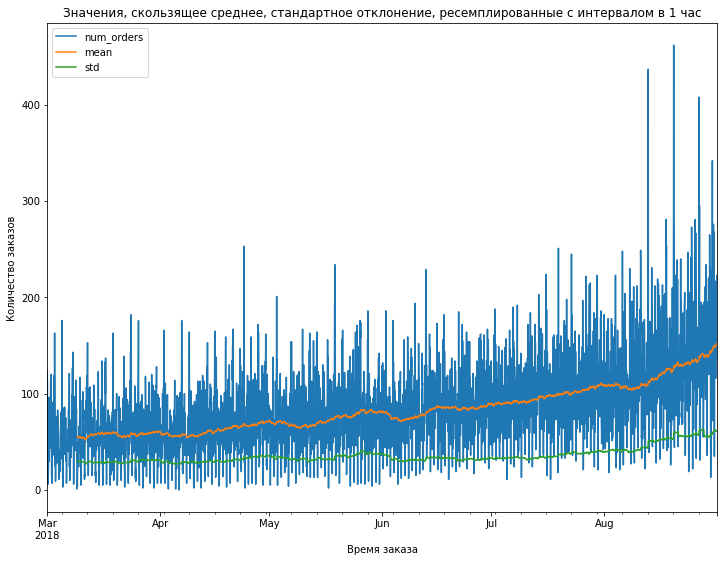

In [7]:
data['mean'] = data['num_orders'].rolling(SAMPLE_SIZE).mean()
data['std'] = data['num_orders'].rolling(SAMPLE_SIZE).std()
data.plot(figsize=[12,9], title='Значения, скользящее среднее, стандартное отклонение, ресемплированные с интервалом в 1 час', xlabel='Время заказа', ylabel='Количество заказов')
#data = data.drop(['mean', 'std'], axis=1)

<AxesSubplot:title={'center':'Разности временного ряда, скользящее среднее, стандартное отклонение'}, xlabel='Время заказа', ylabel='Разности'>

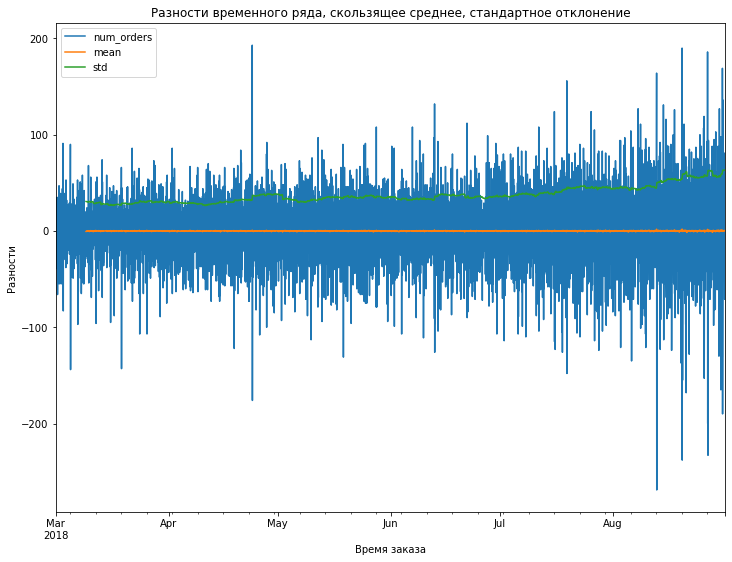

In [8]:
# Берем разностии заменяем ими временной ряд
diff_data = data - data.shift()
diff_data['mean'] = diff_data['num_orders'].rolling(SAMPLE_SIZE).mean()
diff_data['std'] = diff_data['num_orders'].rolling(SAMPLE_SIZE).std()
diff_data.plot(figsize=[12,9], title='Разности временного ряда, скользящее среднее, стандартное отклонение', xlabel='Время заказа', ylabel='Разности')
# diff_data = diff_data.drop('mean', axis=1) # Казалось бы там нули, но удаление этого столбца приводит к падению качества предсказний

## Обучение
* сначала протестируем вариант с предсказанием разностей
* а затем - вариант с предсказанием количеств
### Вариант с разностями (diff_data)

In [9]:
def make_features(dt, max_lag, rolling_mean_size):
    dt['hour'] = dt.index.hour
    dt['month'] = dt.index.month
    dt['day'] = dt.index.day
    dt['dayofweek'] = dt.index.dayofweek
    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt['num_orders'].shift(lag)
    dt['rolling_mean'] = dt['num_orders'].shift().rolling(rolling_mean_size).mean()
    return dt

diff_data = make_features(diff_data, ML, RMS)

In [10]:
train, test = train_test_split(diff_data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
print('Размерность обучающей выборки:', train.shape)
print('Размерность тестовой выборки:', test.shape)
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Размерность обучающей выборки: (3774, 9)
Размерность тестовой выборки: (442, 9)


In [11]:
%%time

model = LinearRegression()
model.fit(train_features, train_target)
pred_train = model.predict(train_features)
pred_test = model.predict(test_features)

print("MAE обучающей выборки:", mean_absolute_error(train_target, pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(test_target, pred_test))

rmse = mean_squared_error(test_target, pred_test, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели LinearRegression на тестовой выборке: {np.round(rmse, 2)}')

MAE обучающей выборки: 22.97581765176394
MAE тестовой выборки:  38.350434506683776
Метрика RMSE модели LinearRegression на тестовой выборке: 49.18
Wall time: 14 ms


In [12]:
%%time

params = {'depth': [4, 6, 8],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,8],
         'iterations': [100, 200]}
cbr = CatBoostRegressor(silent=True, grow_policy='Depthwise')
cbr_model = GridSearchCV(cbr, params, scoring="roc_auc", cv = 3)
cbr_model.fit(train_features, train_target)

print("Лучшие параметры для модели CatBoostRegressor (Depthwise) определенные GridSearchCV:", cbr_model.best_params_)

Лучшие параметры для модели CatBoostRegressor (Depthwise) определенные GridSearchCV: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Wall time: 1min 42s


### Вариант с количествами (data)

In [13]:
true_data = make_features(data, ML, RMS)

true_train, true_test = train_test_split(true_data, shuffle=False, test_size=0.1)
true_train = true_train.dropna()
true_test = true_test.dropna()
print('Размерность обучающей выборки:', true_train.shape)
print('Размерность тестовой выборки:', true_test.shape)
true_train_features = true_train.drop(['num_orders'], axis=1)
true_train_target = true_train['num_orders']
true_test_features = true_test.drop(['num_orders'], axis=1)
true_test_target = true_test['num_orders']

Размерность обучающей выборки: (3775, 9)
Размерность тестовой выборки: (442, 9)


In [14]:
%%time

model = LinearRegression()
model.fit(true_train_features, true_train_target)
pred_train = model.predict(true_train_features)
pred_test = model.predict(true_test_features)

print("MAE обучающей выборки:", mean_absolute_error(true_train_target, pred_train))
print("MAE тестовой выборки: ", mean_absolute_error(true_test_target, pred_test))

rmse = mean_squared_error(true_test_target, pred_test, sample_weight=None, multioutput='uniform_average', squared=False)
print(f'Метрика RMSE модели LinearRegression на тестовой выборке: {np.round(rmse, 2)}')

MAE обучающей выборки: 23.594865666817764
MAE тестовой выборки:  38.90788630142128
Метрика RMSE модели LinearRegression на тестовой выборке: 51.17
Wall time: 7.99 ms


In [23]:
%%time

params = {'depth': [4, 6, 8, 10, 16],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,8],
         'iterations': [100, 200, 300]}
cbr = CatBoostRegressor(silent=True, grow_policy='Lossguide')
cbr_model = GridSearchCV(cbr, params, scoring="neg_mean_squared_error", cv = 5)
cbr_model.fit(true_train_features, true_train_target)

print("Лучшие параметры для модели CatBoostRegressor (Lossguide) определенные GridSearchCV:", cbr_model.best_params_)

Лучшие параметры для модели CatBoostRegressor (Lossguide) определенные GridSearchCV: {'depth': 16, 'iterations': 100, 'l2_leaf_reg': 8, 'learning_rate': 0.15}
Wall time: 8min 34s


In [16]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

grid = GridSearchCV(LGBMRegressor(random_state=RS), params, scoring='r2', cv=5)
grid.fit(true_train_features, true_train_target)

print("Лучшие параметры для модели LGBMRegressor определенные GridSearchCV:", grid.best_params_)

Лучшие параметры для модели LGBMRegressor определенные GridSearchCV: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 28}


## Тестирование
* сначала протестируем вариант с предсказанием разностей
* а затем - вариант с предсказанием количеств
### Вариант с разностями (diff_data)

In [51]:
%%time

models = [LinearRegression(),          
          Ridge(random_state=RS, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          ElasticNet(),
          Lasso(random_state=RS, max_iter=1000),
          DecisionTreeRegressor(random_state=RS, max_depth=6),
          RandomForestRegressor(random_state=RS, n_estimators=80, max_depth=6),
          XGBRegressor(),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=1, learning_rate=0.03, bootstrap_type='MVS', depth=4, grow_policy='Depthwise', iterations=100, silent=True, random_seed=RS),
          LGBMRegressor(objective="regression_l2", n_estimators=50, random_state=RS),
          DummyRegressor(strategy="median")]

results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(train_features, train_target)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    pred = md.predict(test_features)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(test_target, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(test_target, pred), 3)
    print('-- RMSE:', md_rmse)
    print('-- R2:', md_r2)
    results.append({'Модель': md.__class__.__name__, 
                    'RMSE': md_rmse,
                    'R2': md_r2,
                    'Время_обучения': dt1,
                    'Время_предсказания': dt2,                    
                    'Гиперпараметры': md.get_params(deep=False),
                    'Модель_пригодна': md_rmse<=CRIT_RMSE,
                    'pred': pred}) 
    print('')
              
results = pd.DataFrame(results)
display(results.drop('pred', axis=1))

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
-- модель обучена
-- получены предсказания
-- RMSE: 49.18
-- R2: 0.302

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': False, 'random_state': 12345, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- получены предсказания
-- RMSE: 49.17
-- R2: 0.302

Идут вычисления по модели ElasticNet: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- RMSE: 53.58
-- R2: 0.171

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 12345, 'selecti

,Модель,RMSE,R2,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LinearRegression,49.18,0.302,0.0s,0.0s,"{'copy_X': True, 'fit_intercept': True, 'n_job...",False
1,Ridge,49.17,0.302,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
2,ElasticNet,53.58,0.171,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
3,Lasso,49.59,0.290,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
4,DecisionTreeRegressor,46.82,0.367,0.01s,0.0s,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",True
5,RandomForestRegressor,38.17,0.579,0.52s,0.01s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,XGBRegressor,35.82,0.630,0.25s,0.0s,"{'objective': 'reg:squarederror', 'base_score'...",True
7,CatBoostRegressor,39.50,0.550,0.21s,0.0s,"{'iterations': 100, 'learning_rate': 0.03, 'de...",True
8,LGBMRegressor,35.35,0.639,0.04s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
9,DummyRegressor,58.86,-0.000,0.0s,0.0s,"{'constant': None, 'quantile': None, 'strategy...",False


Wall time: 1.11 s


Сравнение данных по результату предсказания модели DecisionTreeRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 14:00:00,102,40.923077,159.923077,-57.923077
2018-08-13 15:00:00,175,109.000000,268.923077,-93.923077
2018-08-13 16:00:00,144,40.923077,309.846154,-165.846154
2018-08-13 17:00:00,152,34.205882,344.052036,-192.052036
2018-08-13 18:00:00,104,-22.523810,321.528227,-217.528227


Сравнение данных по результату предсказания модели RandomForestRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 14:00:00,102,22.347089,141.347089,-39.347089
2018-08-13 15:00:00,175,72.163845,213.510934,-38.510934
2018-08-13 16:00:00,144,-2.859214,210.651720,-66.651720
2018-08-13 17:00:00,152,36.720242,247.371962,-95.371962
2018-08-13 18:00:00,104,-13.772478,233.599484,-129.599484


Сравнение данных по результату предсказания модели XGBRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 14:00:00,102,7.407371,126.407371,-24.407371
2018-08-13 15:00:00,175,45.656487,172.063857,2.936143
2018-08-13 16:00:00,144,-8.198288,163.865569,-19.865569
2018-08-13 17:00:00,152,26.907822,190.773391,-38.773391
2018-08-13 18:00:00,104,-66.873505,123.899886,-19.899886


Сравнение данных по результату предсказания модели CatBoostRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 14:00:00,102,22.720873,141.720873,-39.720873
2018-08-13 15:00:00,175,70.969266,212.690139,-37.690139
2018-08-13 16:00:00,144,-4.712525,207.977614,-63.977614
2018-08-13 17:00:00,152,27.648190,235.625804,-83.625804
2018-08-13 18:00:00,104,-14.801223,220.824581,-116.824581


Сравнение данных по результату предсказания модели LGBMRegressor:


,target,pred,num_orders,error
datetime,,,,
2018-08-13 14:00:00,102,18.459735,137.459735,-35.459735
2018-08-13 15:00:00,175,90.667019,228.126754,-53.126754
2018-08-13 16:00:00,144,-2.172938,225.953816,-81.953816
2018-08-13 17:00:00,152,31.474120,257.427936,-105.427936
2018-08-13 18:00:00,104,-27.551260,229.876676,-125.876676


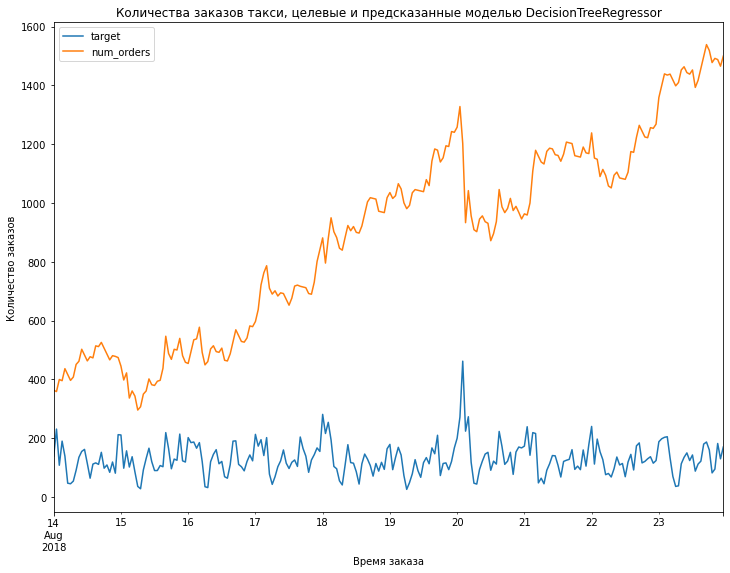

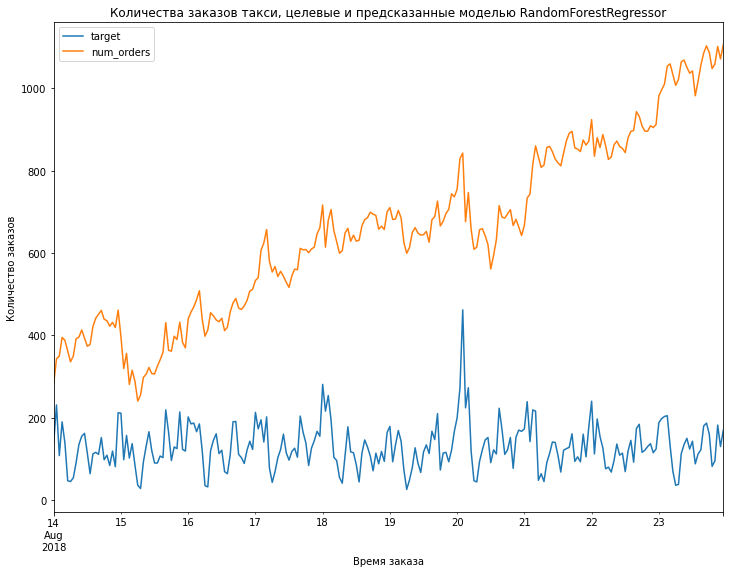

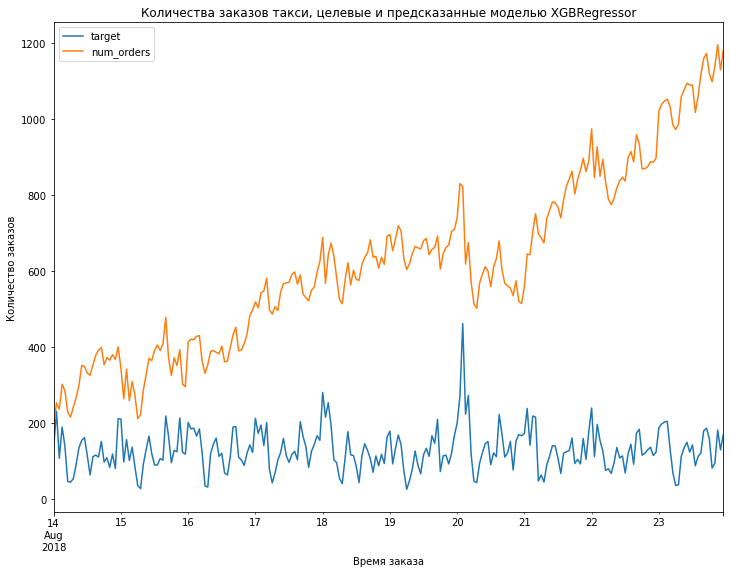

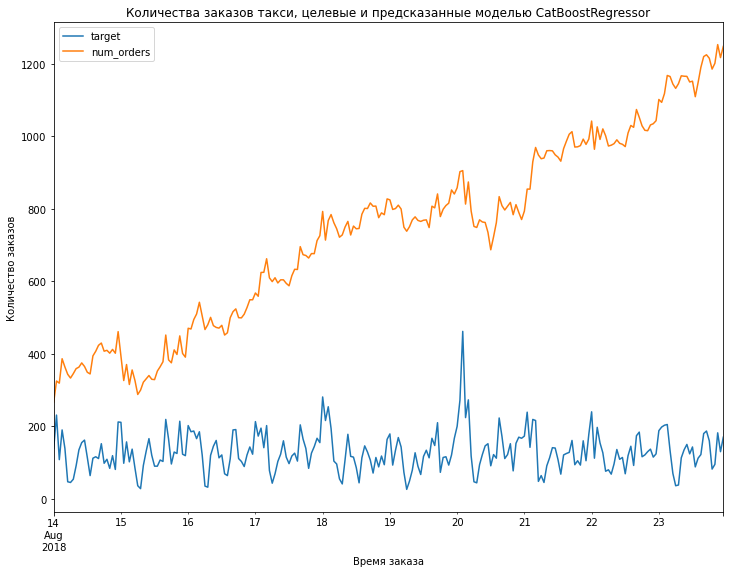

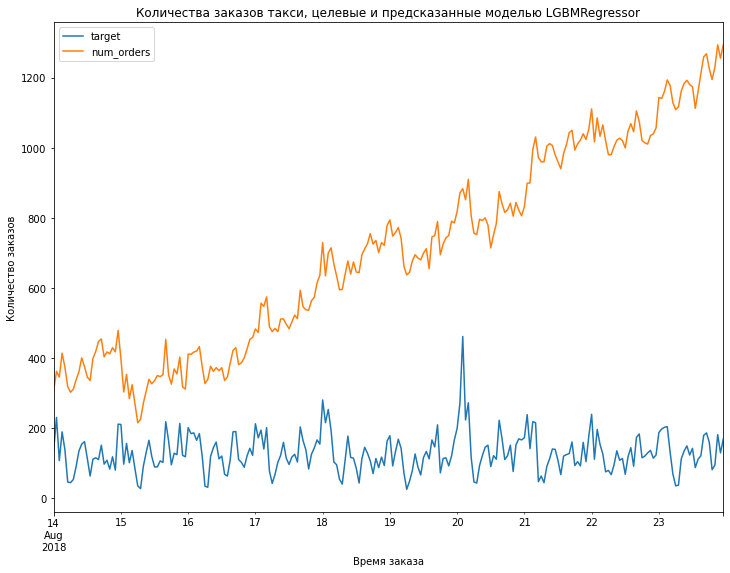

In [53]:
last_num = data.loc[train_target.index[train_target.shape[0]-1],'num_orders'] # берем из исходных данных последнее значение с индексом как в обучающей выборке   

from_test_target = data.loc[test_target.index, 'num_orders'] # берем из исходных данных значения с индексами как в тестовой выборке

model_list = results.query('Модель_пригодна==True')['Модель'].tolist()
for md in model_list:
# Создаем временный датафрейм для сравнения целевых и предсказанных значений
    diff_test_target = pd.DataFrame()
    diff_test_target['target'] = from_test_target
    pred = results.query('Модель==@md').reset_index(drop=True) # чтобы искомый элемент остался с нулевым индексом
    pred = pred.loc[0, 'pred']
    diff_test_target['pred'] = pred
    
# Возвращаемся из разностей к исходным значениям    
    diff_test_target['num_orders'] = 0 # создаем столбец где будут храниться восстановленные значения заказов из разностей
    for i in range(test_target.shape[0]):
        ind = diff_test_target.index[i]
        if i==0:
            diff_test_target.loc[ind, 'num_orders'] = diff_test_target.loc[ind, 'pred'] + last_num # первое значение берем из предсказания и последнегозначения
        else:
            diff_test_target.loc[ind, 'num_orders'] = diff_test_target.loc[ind, 'pred'] + diff_test_target.loc[diff_test_target.index[i-1], 'num_orders'] # добавляем предсказанную разницу к предыдущему значению

# Выводим результаты
    diff_test_target['2018-08-14':'2018-08-23'].drop('pred', axis=1).plot(figsize=[12,9], title='Количества заказов такси, целевые и предсказанные моделью {}'.format(md), xlabel='Время заказа', ylabel='Количество заказов')
    diff_test_target['error'] = diff_test_target['target'] - diff_test_target['num_orders']
    print('Сравнение данных по результату предсказания модели {}:'.format(md))
    display(diff_test_target.head())

### Вариант с количествами (data)

In [55]:
%%time

models = [LinearRegression(),          
          Ridge(random_state=RS, solver='auto', max_iter=15000, fit_intercept=True, normalize=False),
          ElasticNet(),
          Lasso(random_state=RS, max_iter=1000),
          DecisionTreeRegressor(random_state=RS, max_depth=8),
          RandomForestRegressor(random_state=RS, n_estimators=200, max_depth=10),
          XGBRegressor(),
          CatBoostRegressor(loss_function='RMSE', l2_leaf_reg=8, learning_rate=0.15, bootstrap_type='MVS', depth=16, grow_policy='Lossguide', iterations=100, silent=True, random_seed=RS),
          LGBMRegressor(objective="regression_l2", n_estimators=100, random_state=RS),
          DummyRegressor(strategy="median")]

true_results = []

for md in models:
    print(f'Идут вычисления по модели {md.__class__.__name__}:', md.get_params(deep=False))
    t1 = datetime.now() # Засекли время начала обучения
    md.fit(true_train_features, true_train_target)
    t2 = datetime.now() # Время окончания обучения и начала предсказания
    print('-- модель обучена')
    pred = md.predict(true_test_features)
    t3 = datetime.now() # Время окончания предсказания
    print('-- получены предсказания')
    t4 = t2 - t1 # Время обучения
    t5 = t3 - t2 # Время предсказания
    dt1 = str(np.round(t4.total_seconds(), 2))+'s' # Время обучения в секундах
    dt2 = str(np.round(t5.total_seconds(), 2))+'s' # Время предсказания в секундах
    md_rmse = np.round(mean_squared_error(true_test_target, pred, sample_weight=None, multioutput='uniform_average', squared=False), 2)
    md_r2 = np.round(r2_score(true_test_target, pred), 3)
    print('-- RMSE:', md_rmse)
    print('-- R2:', md_r2)
    true_results.append({'Модель': md.__class__.__name__, 
                         'RMSE': md_rmse,
                         'R2': md_r2,
                         'Время_обучения': dt1,
                         'Время_предсказания': dt2,                    
                         'Гиперпараметры': md.get_params(deep=False),
                         'Модель_пригодна': md_rmse<=CRIT_RMSE,
                         'pred': pred}) 
    print('')
              
true_results = pd.DataFrame(true_results)
display(true_results.drop('pred', axis=1))
delta_results = true_results.drop(['Время_обучения', 'Время_предсказания', 'Гиперпараметры', 'Модель_пригодна', 'pred'], axis=1)
delta_results['RMSE_diff'] = results['RMSE']
delta_results['R2_diff'] = results['R2']
display(delta_results)

Идут вычисления по модели LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
-- модель обучена
-- получены предсказания
-- RMSE: 51.17
-- R2: 0.236

Идут вычисления по модели Ridge: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 15000, 'normalize': False, 'random_state': 12345, 'solver': 'auto', 'tol': 0.001}
-- модель обучена
-- получены предсказания
-- RMSE: 51.17
-- R2: 0.236

Идут вычисления по модели ElasticNet: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
-- модель обучена
-- получены предсказания
-- RMSE: 50.9
-- R2: 0.244

Идут вычисления по модели Lasso: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 12345, 'selectio

,Модель,RMSE,R2,Время_обучения,Время_предсказания,Гиперпараметры,Модель_пригодна
0,LinearRegression,51.17,0.236,0.0s,0.0s,"{'copy_X': True, 'fit_intercept': True, 'n_job...",False
1,Ridge,51.17,0.236,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
2,ElasticNet,50.90,0.244,0.0s,0.0s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
3,Lasso,50.79,0.248,0.0s,0.01s,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",False
4,DecisionTreeRegressor,49.25,0.292,0.01s,0.0s,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",False
5,RandomForestRegressor,45.09,0.407,2.18s,0.03s,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",True
6,XGBRegressor,46.34,0.373,0.27s,0.0s,"{'objective': 'reg:squarederror', 'base_score'...",True
7,CatBoostRegressor,42.84,0.465,0.55s,0.0s,"{'iterations': 100, 'learning_rate': 0.15, 'de...",True
8,LGBMRegressor,40.98,0.510,0.06s,0.0s,"{'boosting_type': 'gbdt', 'class_weight': None...",True
9,DummyRegressor,86.41,-1.178,0.0s,0.0s,"{'constant': None, 'quantile': None, 'strategy...",False


,Модель,RMSE,R2,RMSE_diff,R2_diff
0,LinearRegression,51.17,0.236,49.18,0.302
1,Ridge,51.17,0.236,49.17,0.302
2,ElasticNet,50.90,0.244,53.58,0.171
3,Lasso,50.79,0.248,49.59,0.290
4,DecisionTreeRegressor,49.25,0.292,46.82,0.367
5,RandomForestRegressor,45.09,0.407,38.17,0.579
6,XGBRegressor,46.34,0.373,35.82,0.630
7,CatBoostRegressor,42.84,0.465,39.50,0.550
8,LGBMRegressor,40.98,0.510,35.35,0.639
9,DummyRegressor,86.41,-1.178,58.86,-0.000


Wall time: 3.2 s


Сравнение данных по результату предсказания модели LinearRegression:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,112.646350,-10.646350
2018-08-13 15:00:00,175,105.941490,69.058510
2018-08-13 16:00:00,144,138.714074,5.285926
2018-08-13 17:00:00,152,125.410076,26.589924
2018-08-13 18:00:00,104,129.328486,-25.328486


Сравнение данных по результату предсказания модели Ridge:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,112.646776,-10.646776
2018-08-13 15:00:00,175,105.941888,69.058112
2018-08-13 16:00:00,144,138.714474,5.285526
2018-08-13 17:00:00,152,125.410467,26.589533
2018-08-13 18:00:00,104,129.328875,-25.328875


Сравнение данных по результату предсказания модели ElasticNet:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,114.600200,-12.600200
2018-08-13 15:00:00,175,107.824170,67.175830
2018-08-13 16:00:00,144,140.605123,3.394877
2018-08-13 17:00:00,152,127.279890,24.720110
2018-08-13 18:00:00,104,131.183016,-27.183016


Сравнение данных по результату предсказания модели Lasso:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,115.382478,-13.382478
2018-08-13 15:00:00,175,108.572876,66.427124
2018-08-13 16:00:00,144,141.359402,2.640598
2018-08-13 17:00:00,152,128.023633,23.976367
2018-08-13 18:00:00,104,131.907169,-27.907169


Сравнение данных по результату предсказания модели DecisionTreeRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,97.243243,4.756757
2018-08-13 15:00:00,175,97.243243,77.756757
2018-08-13 16:00:00,144,137.000000,7.000000
2018-08-13 17:00:00,152,137.000000,15.000000
2018-08-13 18:00:00,104,74.882353,29.117647


Сравнение данных по результату предсказания модели RandomForestRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,112.313138,-10.313138
2018-08-13 15:00:00,175,123.569273,51.430727
2018-08-13 16:00:00,144,136.043917,7.956083
2018-08-13 17:00:00,152,135.151713,16.848287
2018-08-13 18:00:00,104,103.351997,0.648003


Сравнение данных по результату предсказания модели XGBRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,123.373421,-21.373421
2018-08-13 15:00:00,175,131.030792,43.969208
2018-08-13 16:00:00,144,159.523193,-15.523193
2018-08-13 17:00:00,152,136.600983,15.399017
2018-08-13 18:00:00,104,115.439919,-11.439919


Сравнение данных по результату предсказания модели CatBoostRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,110.010622,-8.010622
2018-08-13 15:00:00,175,125.842017,49.157983
2018-08-13 16:00:00,144,146.804607,-2.804607
2018-08-13 17:00:00,152,135.462938,16.537062
2018-08-13 18:00:00,104,102.370358,1.629642


Сравнение данных по результату предсказания модели LGBMRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,119.987601,-17.987601
2018-08-13 15:00:00,175,132.810504,42.189496
2018-08-13 16:00:00,144,146.088568,-2.088568
2018-08-13 17:00:00,152,143.972480,8.027520
2018-08-13 18:00:00,104,109.396680,-5.396680


Сравнение данных по результату предсказания модели DummyRegressor:


,target,num_orders,error
datetime,,,
2018-08-13 14:00:00,102,76.0,26.0
2018-08-13 15:00:00,175,76.0,99.0
2018-08-13 16:00:00,144,76.0,68.0
2018-08-13 17:00:00,152,76.0,76.0
2018-08-13 18:00:00,104,76.0,28.0


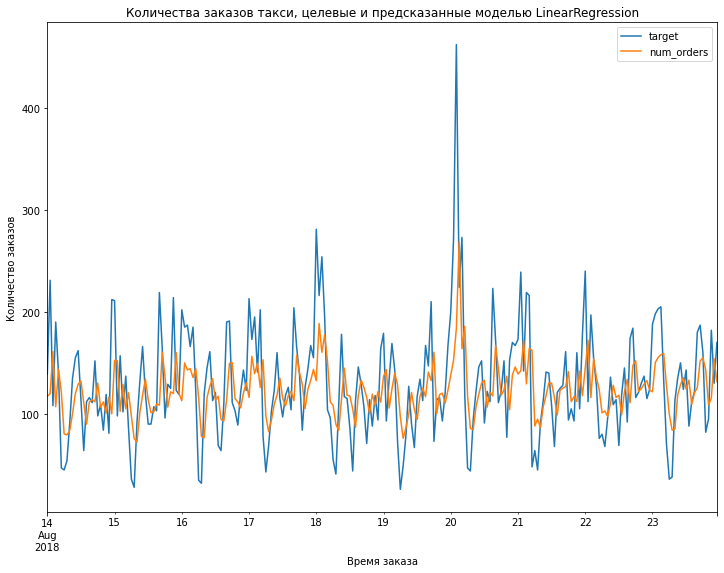

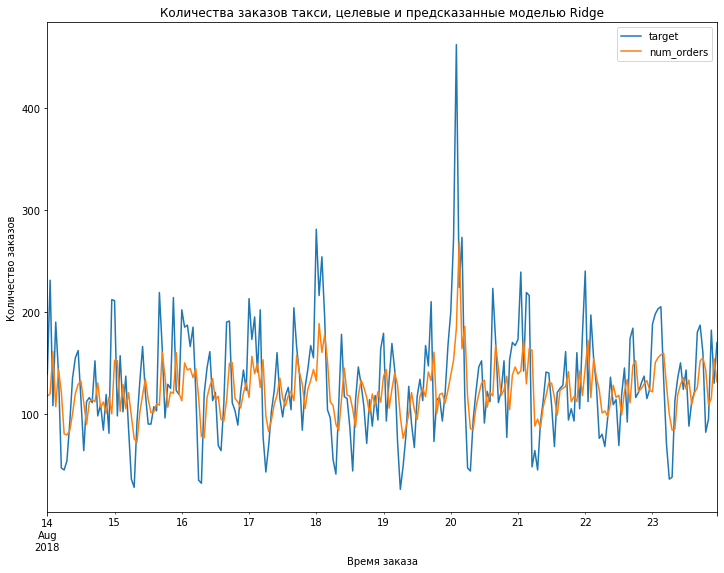

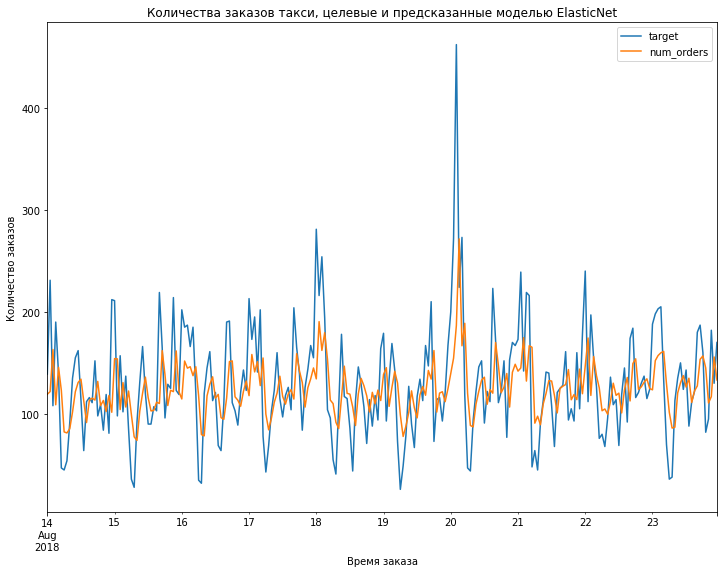

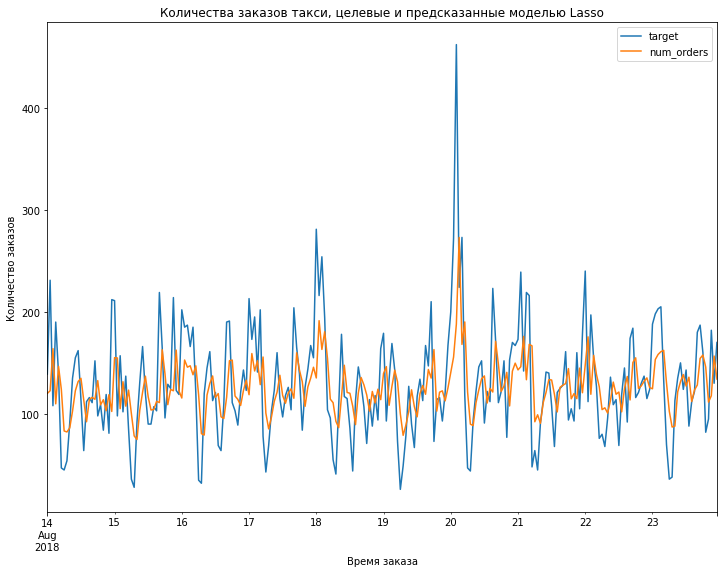

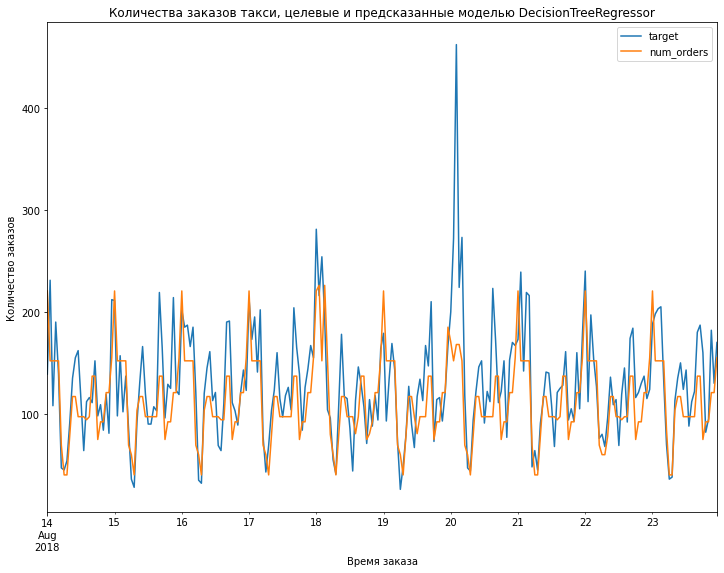

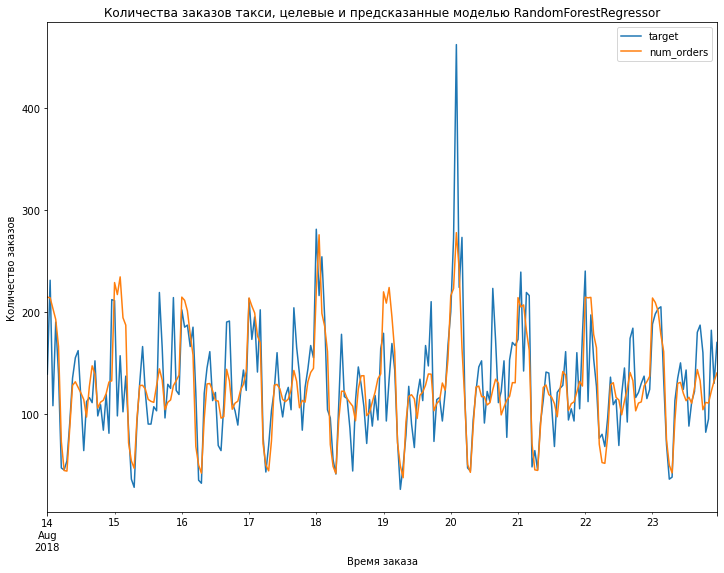

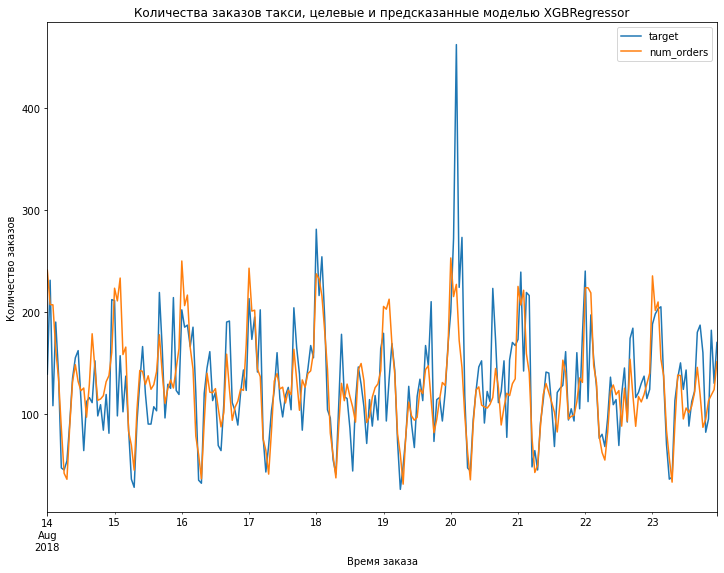

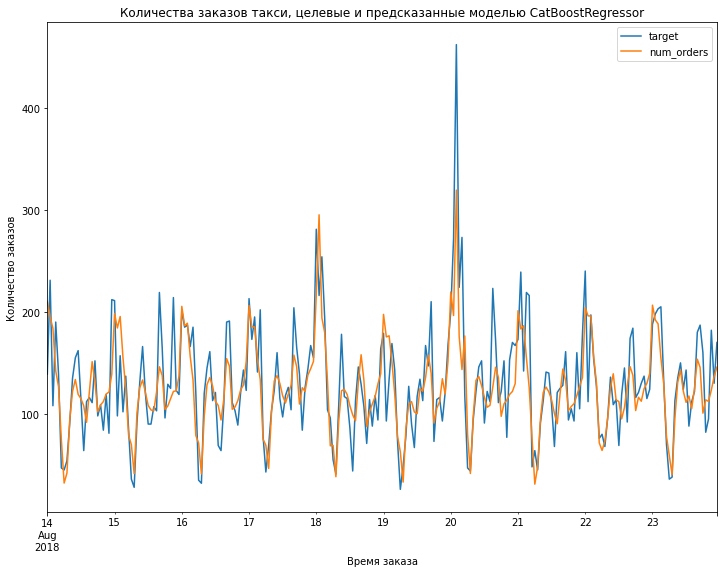

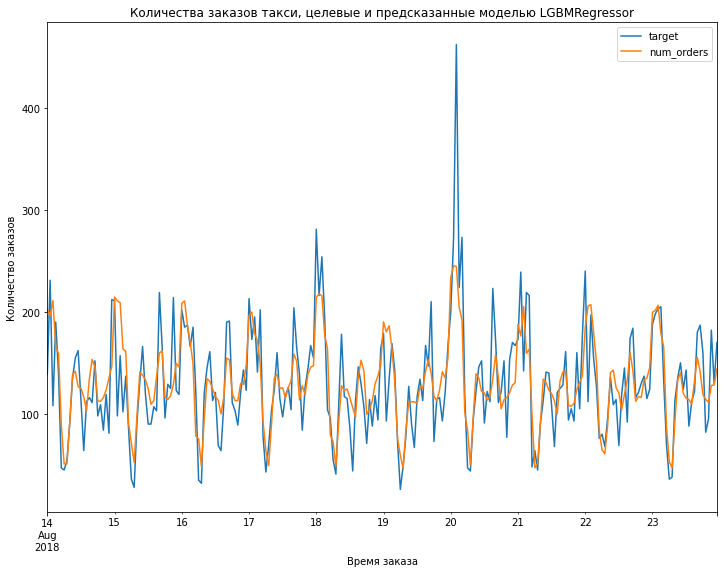

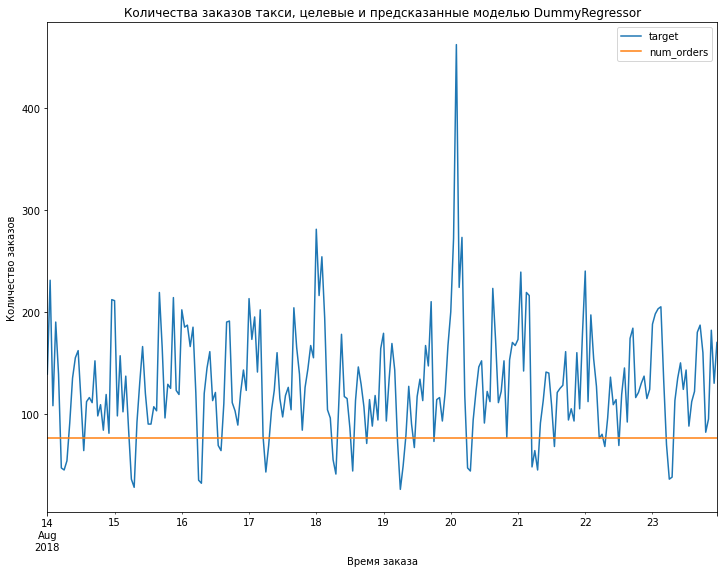

In [56]:
from_test_target = data.loc[true_test_target.index, 'num_orders'] # берем из исходных данных значения с индексами как в тестовой выборке

model_list = true_results['Модель'].tolist() # не сортировал по пригодности чтобы показать наличие сдвига у моделей линиейной регрессии
for md in model_list:
# Создаем временный датафрейм для сравнения целевых и предсказанных значений
    diff_test_target = pd.DataFrame()
    diff_test_target['target'] = from_test_target
    pred = true_results.query('Модель==@md').reset_index(drop=True) # чтобы искомый элемент остался с нулевым индексом
    pred = pred.loc[0, 'pred']
    diff_test_target['num_orders'] = pred

# Выводим результаты
    diff_test_target['2018-08-14':'2018-08-23'].plot(figsize=[12,9], title='Количества заказов такси, целевые и предсказанные моделью {}'.format(md), xlabel='Время заказа', ylabel='Количество заказов')
    diff_test_target['error'] = diff_test_target['target'] - diff_test_target['num_orders']
    print('Сравнение данных по результату предсказания модели {}:'.format(md))
    display(diff_test_target.head())

## Выводы:
1. Восстановление количеств из предсказаний разницы (вне зависимости от показаний метрики) приводит к очень плохому результату (большая ошибка). Несмотря на то, что временной ряд разниц более стационарен, предсказывать нужно именно количества напрямую.
2. Несмотря на более лучшие значения метрик предсказаний разницы, конечный результат получается значительно хуже.
3. Предсказания количеств в моделях линейной регрессии опаздывают по времени по сравнению с целевым признаком, а в моделях градиентного бустинга этой ошибки нет.
4. При заданных гиперпараметрах, при предсказнии количеств наилучшая метрика RMSE=40.98 получилась для модели LGBMRegressor (она же имеет малое время обучения)
5. Качество предсказания даже у самой лучшей модели довольно низкое (R2=0.510), но в заданный порог RMSE<=48 укладываются многие из моделей: RandomForestRegressor, XGBRegressor, CatBoostRegressor, LGBMRegressor
6. RandomForestRegressor и DecisionTreeRegressor сглаживают многие всплески (у моделей линейной регрессии такойошибки нет), из-за чего идут ошибки предсказания.